
# <span style="color:rgb(213,80,0)">Joint Angle Analysis Tutorial</span>

**Sean Osis, Allan Brett, Reed Ferber, Reginaldo Fukuchi, Blayne Hettinga**


### Purpose

The purpose of this tutorial is to demonstrate the application of techniques for quantitatively determining differences in joint angles.

-  Principal component analysis for dimensionality reduction
-  Identifying significant differences based on component analysis
-  Statistical parametric mapping to determine significantly different sections of joint angle time\-series

**Requirements**

-  MATLAB 2016a or later and a supported OS
-  MATLAB Statistics and Machine Learning Toolbox
-  The SPM1D code package authord by Dr. Todd Pataky
-  Code package included with supplemental material
-  Data file saved from the Joint Angle Exploration Tutorial
### Load Data Set

In this section, data are loaded from the previous tutorial (\#2) and separated into replicate sets.


In [1]:
% Load data from previous tutorial
load('tutorial_2.mat')
whos

  Name           Size              Bytes  Class    Attributes
  group_f      189x12            1055008  table              
  group_m      189x12            1054608  table

In [2]:
% Add labels for each angle
labels = {'Left Hip Abduction', ...
          'Left Hip External Rotation', ...
          'Left Hip Extension', ...
          'Right Hip Adduction', ...
          'Right Hip Internal Rotation', ...
          'Right Hip Extension'};


In [3]:
% Randomly split the data into 2 sets for replicate analysis

set1 = randperm(height(group_m), ceil(height(group_m)/2));
set2 = 1:height(group_m);
set2 = set2(~ismember(set2,set1));

group_m1 = group_m(set1,:);
group_m2 = group_m(set2,:);

group_f1 = group_f(set1,:);
group_f2 = group_f(set2,:);


### Using Principal Component Analysis

Joint angle data can be analyzed through dimensionality reduction using PCA to identify primary sources of variance \[1\] and then performing statistical comparisons on components in order to determine where significant differences exist \[2\].


In [4]:
% Organize data for males
% 2D matrix of N x ts
% N = subjects
% ts = concatenated timeseries points

pcam = cellfun(@(x) x(:,1),group_m1.left_hip,'un',0);
pcam = horzcat(pcam{:});

tmp = cellfun(@(x) x(:,2),group_m1.left_hip,'un',0);
tmp = horzcat(tmp{:});

pcam = vertcat(pcam,tmp);

tmp = cellfun(@(x) x(:,3),group_m1.left_hip,'un',0);
tmp = horzcat(tmp{:});

pcam = vertcat(pcam,tmp);

tmp = cellfun(@(x) x(:,1),group_m1.right_hip,'un',0);
tmp = horzcat(tmp{:});

pcam = vertcat(pcam,tmp);

tmp = cellfun(@(x) x(:,2),group_m1.right_hip,'un',0);
tmp = horzcat(tmp{:});

pcam = vertcat(pcam,tmp);

tmp = cellfun(@(x) x(:,3),group_m1.right_hip,'un',0);
tmp = horzcat(tmp{:});

pcam = vertcat(pcam,tmp);

pcam = pcam';


In [5]:
% Organize data for females
% 2D matrix of N x ts
% N = subjects
% ts = concatenated timeseries points

pcaf = cellfun(@(x) x(:,1),group_f1.left_hip,'un',0);
pcaf = horzcat(pcaf{:});

tmp = cellfun(@(x) x(:,2),group_f1.left_hip,'un',0);
tmp = horzcat(tmp{:});

pcaf = vertcat(pcaf,tmp);

tmp = cellfun(@(x) x(:,3),group_f1.left_hip,'un',0);
tmp = horzcat(tmp{:});

pcaf = vertcat(pcaf,tmp);

tmp = cellfun(@(x) x(:,1),group_f1.right_hip,'un',0);
tmp = horzcat(tmp{:});

pcaf = vertcat(pcaf,tmp);

tmp = cellfun(@(x) x(:,2),group_f1.right_hip,'un',0);
tmp = horzcat(tmp{:});

pcaf = vertcat(pcaf,tmp);

tmp = cellfun(@(x) x(:,3),group_f1.right_hip,'un',0);
tmp = horzcat(tmp{:});

pcaf = vertcat(pcaf,tmp);

pcaf = pcaf';



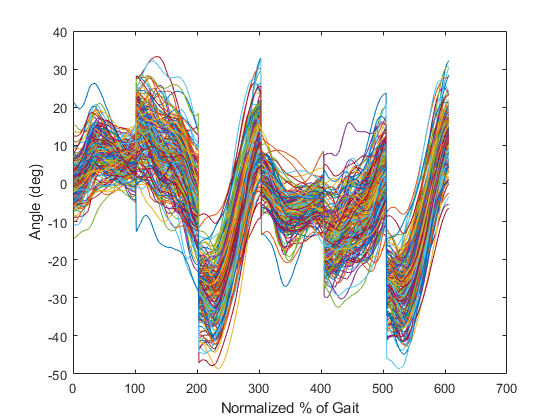

In [6]:
% Combine data

pcad = vertcat(pcaf,pcam);

% Visualize
% Note that directions are flipped between left and right for frontal and
% transverse planes

figure;
plot(pcad')
xlabel('Normalized % of Gait')
ylabel('Angle (deg)')

In [7]:
% Run PCA
[coeff, scores, ~, ~, explainvar] = pca(pcad, 'Centered',true);



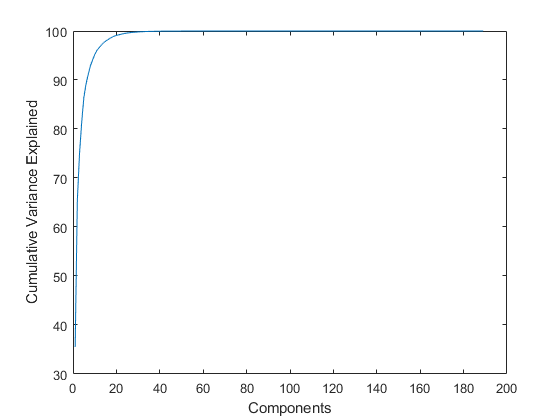

In [8]:
% Explained variance
figure;
plot(cumsum(explainvar))
xlabel('Components')
ylabel('Cumulative Variance Explained')


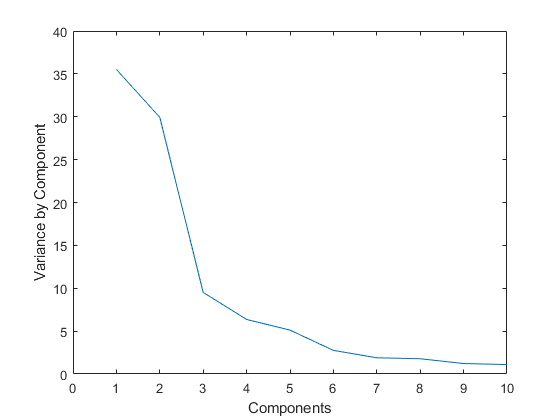

In [9]:

figure;
plot(explainvar)
xlim([0 10])
xlabel('Components')
ylabel('Variance by Component')


Greater than 90% of variance is captured in the first 10 components. Examining variance by component, it is apparent that diminishing variance is captured after component 6. We can therefore compare component scores between male and female groups for the first components.



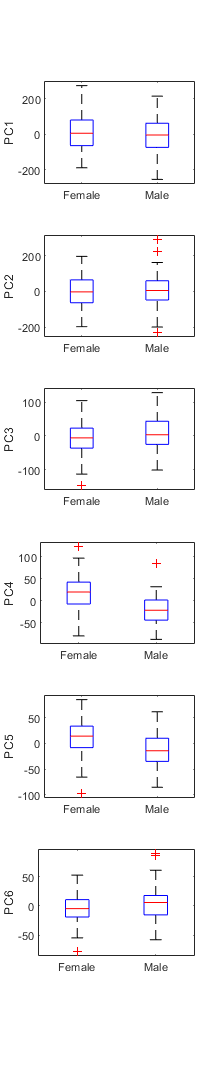

In [10]:
% Select n components based on variance explained
n_cpts = 6;

% Boxplot and stats for scores
grp = cell(size(pcad,1),1);
grp(1:size(pcaf,1)) = {'Female'};
grp(size(pcaf,1)+1:end) = {'Male'};

fig = figure('units','inch','position',[0,0,5,25]);

for i = 1:n_cpts
    subplot(n_cpts,1,i);
    boxplot(scores(:,i),grp)
    ylabel(['PC' num2str(i)])
end


The largest difference between males and females is seen in component 4. Therefore, we can examine a reconstruction of the data on component 4 using a technique published by Brandon et al. \[3\].


In [11]:
% Component reconstruction based on Brandon et al.

cn = 4;

xbar = mean(pcad,1);

z95_f = quantile(scores(1:size(pcaf,1),cn),0.95);
z05_f = quantile(scores(1:size(pcaf,1),cn),0.05);

z95_m = quantile(scores(size(pcaf,1)+1:end,cn),0.95);
z05_m = quantile(scores(size(pcaf,1)+1:end,cn),0.05);

xU_f = xbar + (coeff(:,cn)*z95_f)';
xL_f = xbar + (coeff(:,cn)*z05_f)';

xU_m = xbar + (coeff(:,cn)*z95_m)';
xL_m = xbar + (coeff(:,cn)*z05_m)';



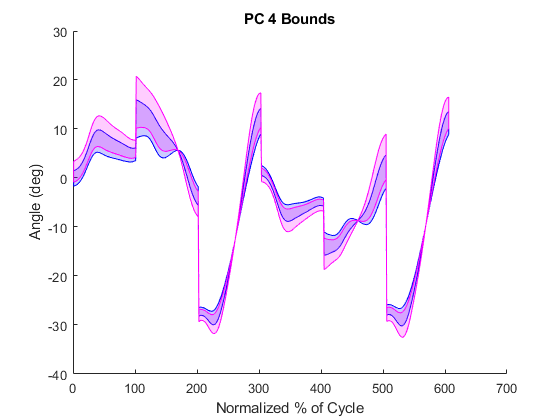

In [12]:
figure;
hold on
fill([1:length(xU_m),fliplr(1:length(xU_m))],[xU_m,fliplr(xL_m)],'b',"FaceAlpha",0.2,"EdgeColor",'b')
fill([1:length(xU_f),fliplr(1:length(xL_f))],[xU_f,fliplr(xL_f)],'m',"FaceAlpha",0.2,"EdgeColor",'m')
title(['PC ' num2str(cn) ' Bounds'])
xlabel('Normalized % of Cycle')
ylabel('Angle (deg)')


Based on the reconstructed boundaries for male and female groups on component 4, the largest differences appear to be in the frontal plane, a finding which agrees with prior findings from research into male and female running patterns \[4,5\].

### Analysis using Statistical Parametric Mapping

In this section, hip joint angles are compared between males and females using statistical parametric mapping (SPM) to determine whether significant differences exist and where in the time series those differences are located \[6\].


In [13]:
% Reorganize data for males + females
% 3D matrix of N x ts x R
% N = subjects
% ts = timeseries points
% R = variables

smpf = zeros(size(group_f1,1),101,6);

for i = 1:size(smpf,1)
    smpf(i,:,:) = horzcat(group_f1{i,'left_hip'}{:},group_f1{i, 'right_hip'}{:});
end

smpm = zeros(size(group_m1,1),101,6);

for i = 1:size(smpm,1)
    smpm(i,:,:) = horzcat(group_m1{i,'left_hip'}{:},group_m1{i, 'right_hip'}{:});
end


In [14]:
% Run Hotelling's T2 test

alpha      = 0.05;
iterations = 200;
snpm       = spm1d.stats.nonparam.hotellings2(smpm, smpf);
snpmi      = snpm.inference(alpha, 'iterations', iterations);
disp('Result of Hotellings T')

Result of Hotellings T

In [15]:
disp( snpmi )

SnPM{T2} inference (1D)
              z: [1x101 double]
    nPermUnique: Inf
    nPermActual: 200.00
          alpha: 0.05
          zstar: 18.81
       h0reject: 1
              p: [0.01 0.01]


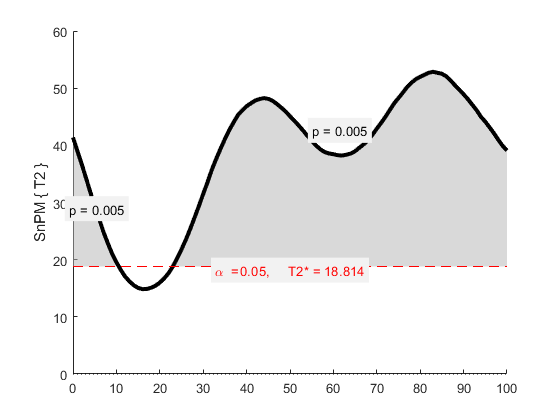

In [16]:

figure;
snpmi.plot();
snpmi.plot_threshold_label();
snpmi.plot_p_values();


According to the results of the Hotelling's T2, the combination of all 6 joint angles (left + right x 3 planes) produces significant differences between males and females during nearly all of stance. We can therefore run post\-hoc tests to determine which planes and timepoints contain these differences,


Result of Left Hip Abduction Post-Hoc
SnPM{t} inference (1D)
              z: [1x101 double]
    nPermUnique: Inf
    nPermActual: 200.00
          alpha: 0.01
          zstar: 2.88
       h0reject: 1
              p: 0.01


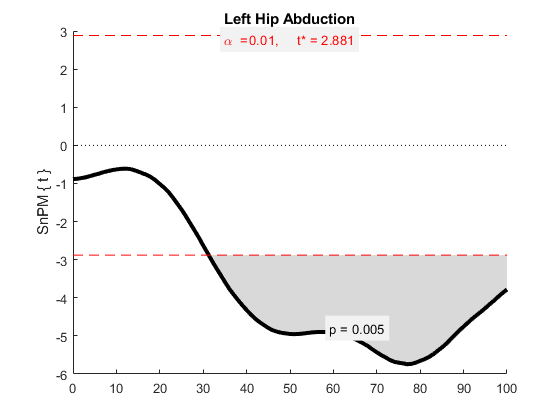

Result of Left Hip External Rotation Post-Hoc
SnPM{t} inference (1D)
              z: [1x101 double]
    nPermUnique: Inf
    nPermActual: 200.00
          alpha: 0.01
          zstar: 3.36
       h0reject: 0
              p: [1x0 double]


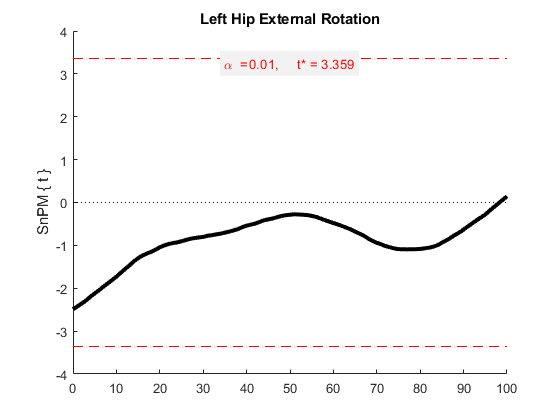

Result of Left Hip Extension Post-Hoc
SnPM{t} inference (1D)
              z: [1x101 double]
    nPermUnique: Inf
    nPermActual: 200.00
          alpha: 0.01
          zstar: 2.79
       h0reject: 0
              p: [1x0 double]


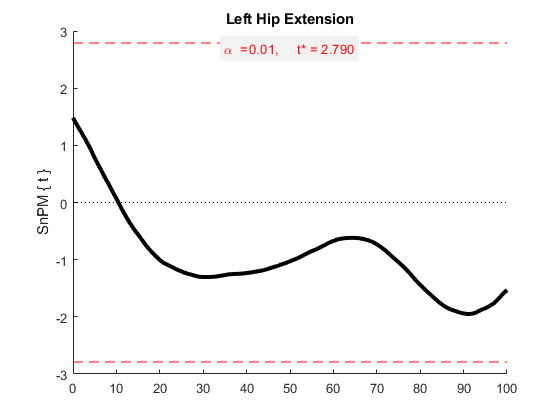

Result of Right Hip Adduction Post-Hoc
SnPM{t} inference (1D)
              z: [1x101 double]
    nPermUnique: Inf
    nPermActual: 200.00
          alpha: 0.01
          zstar: 3.63
       h0reject: 1
              p: 0.01


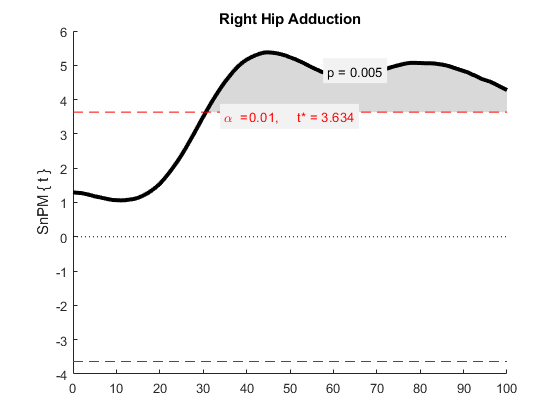

Result of Right Hip Internal Rotation Post-Hoc
SnPM{t} inference (1D)
              z: [1x101 double]
    nPermUnique: Inf
    nPermActual: 200.00
          alpha: 0.01
          zstar: 3.49
       h0reject: 1
              p: 0.01


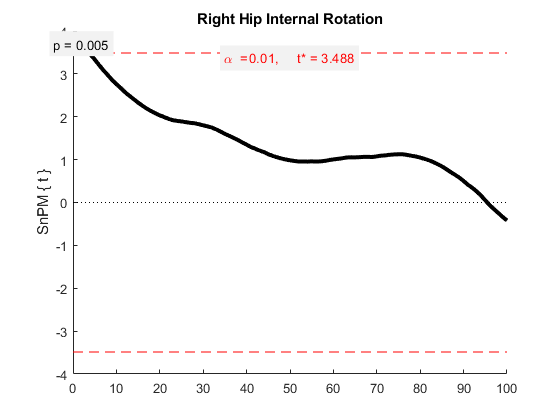

Result of Right Hip Extension Post-Hoc
SnPM{t} inference (1D)
              z: [1x101 double]
    nPermUnique: Inf
    nPermActual: 200.00
          alpha: 0.01
          zstar: 3.17
       h0reject: 0
              p: [1x0 double]


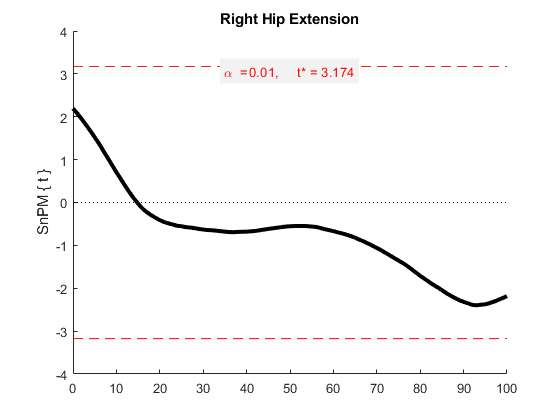

In [17]:
% Run Bonferroni corrected post hocs between individual joint angles

alpha      = 0.05/6;
two_tailed = true;
iterations = 200;

for i = 1:6

    t  = spm1d.stats.nonparam.ttest2(smpm(:,:,i), smpf(:,:,i));
    ti = t.inference(alpha, 'two_tailed', two_tailed, 'iterations', iterations);
    disp(['Result of ' labels{i} ' Post-Hoc'])
    disp(ti)

    figure;
    ti.plot();
    ti.plot_threshold_label();
    ti.plot_p_values();
    title(labels{i})

end


Based on the corrected post\-hoc tests, the largest significant differences exist in the frontal plane, during approximately 40\-100% of stance. This agrees with prior research which indicates that females generally exhibit larger hip adduction during stance as compared with males \[4,5\].

### Run SPM Analysis on Replicate

In this section we run the same SPM analysis to determine whether we can reproduce the results using our holdout replicate data set.


In [18]:
smpf = zeros(size(group_f2,1),101,6);

for i = 1:size(smpf,1)
    smpf(i,:,:) = horzcat(group_f2{i,'left_hip'}{:},group_f2{i, 'right_hip'}{:});
end

smpm = zeros(size(group_m2,1),101,6);

for i = 1:size(smpm,1)
    smpm(i,:,:) = horzcat(group_m2{i,'left_hip'}{:},group_m2{i, 'right_hip'}{:});
end


In [19]:
% Run Hotelling's T2 test

alpha      = 0.05;
iterations = 200;
snpm       = spm1d.stats.nonparam.hotellings2(smpm, smpf);
snpmi      = snpm.inference(alpha, 'iterations', iterations);
disp('Result of Hotellings T')

Result of Hotellings T

In [20]:
disp( snpmi )

SnPM{T2} inference (1D)
              z: [1x101 double]
    nPermUnique: Inf
    nPermActual: 200.00
          alpha: 0.05
          zstar: 17.88
       h0reject: 1
              p: [0.01 0.01]


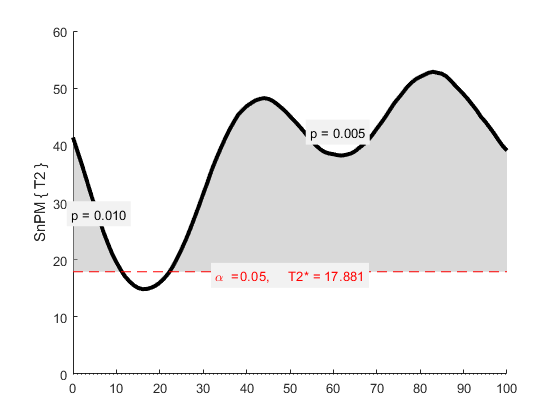

In [21]:

figure;
snpmi.plot();
snpmi.plot_threshold_label();
snpmi.plot_p_values();

Result of Left Hip Abduction Post-Hoc
SnPM{t} inference (1D)
              z: [1x101 double]
    nPermUnique: Inf
    nPermActual: 200.00
          alpha: 0.01
          zstar: 3.01
       h0reject: 1
              p: 0.01


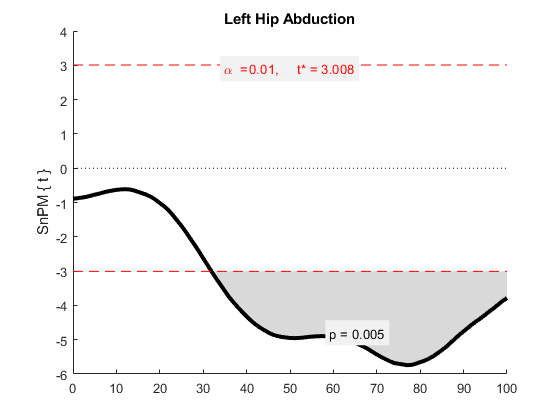

Result of Left Hip External Rotation Post-Hoc
SnPM{t} inference (1D)
              z: [1x101 double]
    nPermUnique: Inf
    nPermActual: 200.00
          alpha: 0.01
          zstar: 2.72
       h0reject: 0
              p: [1x0 double]


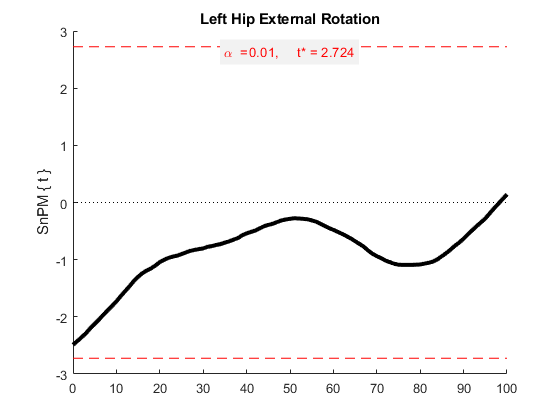

Result of Left Hip Extension Post-Hoc
SnPM{t} inference (1D)
              z: [1x101 double]
    nPermUnique: Inf
    nPermActual: 200.00
          alpha: 0.01
          zstar: 2.46
       h0reject: 0
              p: [1x0 double]


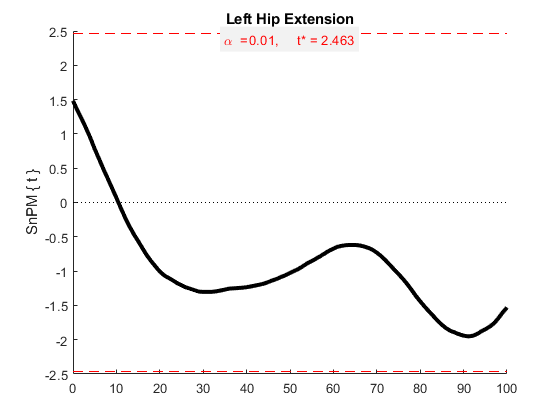

Result of Right Hip Adduction Post-Hoc
SnPM{t} inference (1D)
              z: [1x101 double]
    nPermUnique: Inf
    nPermActual: 200.00
          alpha: 0.01
          zstar: 3.11
       h0reject: 1
              p: 0.01


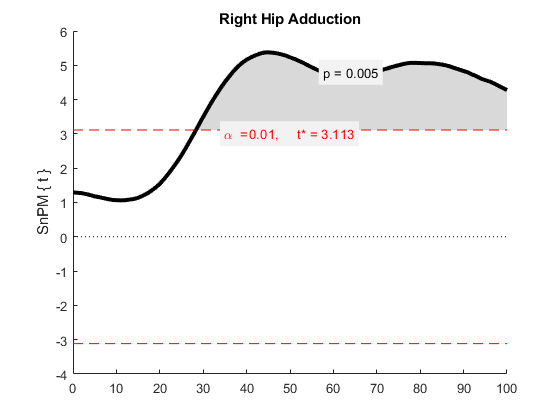

Result of Right Hip Internal Rotation Post-Hoc
SnPM{t} inference (1D)
              z: [1x101 double]
    nPermUnique: Inf
    nPermActual: 200.00
          alpha: 0.01
          zstar: 3.47
       h0reject: 1
              p: 0.01


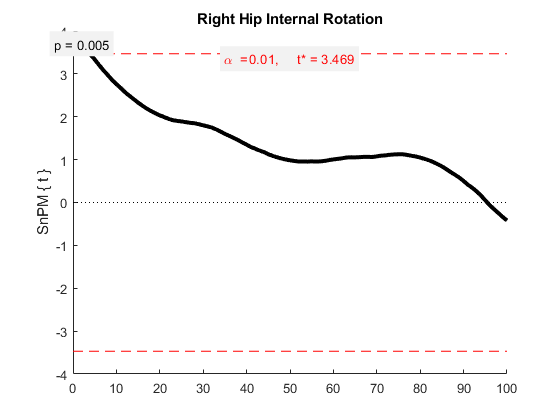

Result of Right Hip Extension Post-Hoc
SnPM{t} inference (1D)
              z: [1x101 double]
    nPermUnique: Inf
    nPermActual: 200.00
          alpha: 0.01
          zstar: 3.40
       h0reject: 0
              p: [1x0 double]


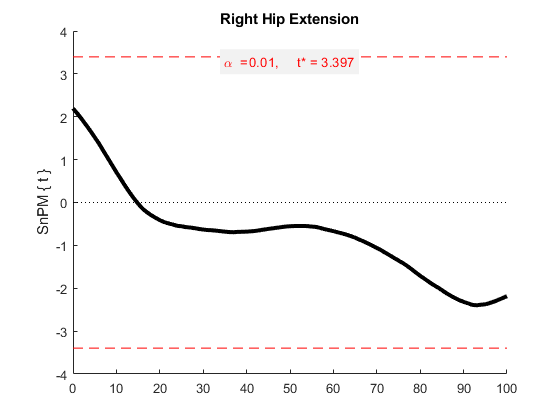

In [22]:
% Run bonferroni corrected post hocs between individual joint angles

alpha      = 0.05/6;
two_tailed = true;
iterations = 200;

for i = 1:6

    t  = spm1d.stats.nonparam.ttest2(smpm(:,:,i), smpf(:,:,i));
    ti = t.inference(alpha, 'two_tailed', two_tailed, 'iterations', iterations);
    disp(['Result of ' labels{i} ' Post-Hoc'])
    disp(ti)

    figure;
    ti.plot();
    ti.plot_threshold_label();
    ti.plot_p_values();
    title(labels{i})

end


The second replicate data set produces very similar findings to the first, and there are significant differences in the frontal plane from approximatly 30\-100% of stance, in agreement with our first replicate findings.

### Interpretation

For a matched cohort of runners, females exhibited increased hip adduction during the latter 60\-70% of stance. These findings agree with prior findings for hip kinematics when comparing males and females.


Given that both replicates produced similar findings for the frontal plane, this suggests that those results are robust and likely to be reproducible.

### References

\[1\] Deluzio KJ, Wyss UP, Zee B, Costigan PA, Serbie C. Principal component models of knee kinematics and kinetics: Normal vs. pathological gait patterns. Human Movement Science. 1997 16(2\-3):201\-217.


\[2\] Pataky TC. Generalized n\-dimensional  biomechanical field analysis using statistical parametric mapping. J  Biomech. 2010 Jul 20;43(10):1976\-82.


\[3\] Brandon SC, Graham RB, Almosnino S, Sadler  EM, Stevenson JM, Deluzio KJ. Interpreting principal components in biomechanics: representative extremes and single component reconstruction. J Electromyogr Kinesiol. 2013 Dec;23(6):1304\-10.


\[4\] Ferber R, Davis IM, Williams III DS. Gender differences in lower extremity mechanics during running. Clin Biomech. 2003 May;18(4):350\-7.


\[5\] Gehring D, Mornieux G, Fleischmann J, Gollhofer A. Knee and Hip Joint Biomechanics are Gender\-specific in Runners with High Running Mileage. Int J Sports Med 2014; 35(02):153\-8.


\[6\] Pataky, TC. SPM1D \[Computer software\]. 2014. Retrieved from https://spm1d.org/index.html

